In [93]:
%load_ext autoreload
%autoreload 2
import os
from copy import copy
import pickle as pkl
from os.path import join as oj
from collections import defaultdict
import warnings

warnings.filterwarnings(action="ignore", category=UserWarning)

import imodels
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imodels.util import data_util
from numpy import concatenate as npcat
from tqdm import tqdm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
mpl.rcParams['figure.dpi'] = 250
np.random.seed(0)

# change working directory to project root
while os.getcwd().split('/')[-1] != 'imodels-experiments':
    os.chdir('..')

import common

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
DATASET = 'tbi'
RESULT_PATH = f'notebooks/transfertree/results/{DATASET}'
if not os.path.exists(RESULT_PATH):
    os.makedirs(RESULT_PATH)

if DATASET == 'csi':
    suffix = '_old'
else:
    suffix = ''

In [95]:
class TransferTree:
    def __init__(self, model_0, model_1, model_1_log_arr):
        self.model_0 = model_0
        self.model_1 = model_1
        self.model_1_log_arr = model_1_log_arr

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

    def predict_proba(self, X):
        preds_proba = np.zeros((X.shape[0], 2))
        preds_proba[~self.model_1_log_arr] = self.model_0.predict_proba(
            X[~self.model_1_log_arr])
        preds_proba[self.model_1_log_arr] = self.model_1.predict_proba(
            X[self.model_1_log_arr])
        return preds_proba

class PECARNModel:
    def __init__(self, young):
        self.young = young

    def predict(self, X: pd.DataFrame):
        if DATASET == 'tbi' and self.young:
            factors_sum = (
                X['AMS'] + X['HemaLoc_Occipital'] + X['HemaLoc_Parietal/Temporal'] + X['LocLen_1-5 min'] + 
                X['LocLen_5 sec - 1 min'] + X['LocLen_>5 min'] + X['High_impact_InjSev_High'] + 
                X['SFxPalp_Unclear'] + X['SFxPalp_Yes'] + (1 - X['ActNorm']))
        elif DATASET == 'tbi':
            factors_sum = (
                X['AMS'] + X['Vomit'] + X['LOCSeparate_Suspected'] + X['LOCSeparate_Yes'] + 
                X['High_impact_InjSev_High'] + X['SFxBas'] +  X['HASeverity_Severe'])
        elif DATASET == 'csi':
            factors_sum = (
                X['AlteredMentalStatus2'] + X['PainNeck2'] + X['FocalNeuroFindings2'] + 
                X['Torticollis2'] + X['subinj_TorsoTrunk2'] + X['Predisposed'] + 
                X['HighriskDiving'] + X['HighriskMVC']
            )
        elif DATASET == 'iai':
            factors_sum = (
                X['AbdTrauma_or_SeatBeltSign_yes'] + (X['GCSScore'] <= 13).astype(int) + 
                X['AbdTenderDegree_Mild'] + X['AbdTenderDegree_Moderate'] + 
                X['AbdTenderDegree_Severe'] + X['ThoracicTrauma_yes'] + X['AbdomenPain_yes'] +
                X['DecrBreathSound_yes'] + X['VomitWretch_yes']
            )
        preds = (factors_sum >= 1).astype(int)

        return preds.values
    
    def predict_proba(self, X: pd.DataFrame):
        preds = np.expand_dims(self.predict(X), axis=1)
        return np.hstack((1 - preds, preds))

In [96]:
X, y, feature_names = data_util.get_clean_dataset(
    f'{DATASET}_pecarn_pred{suffix}.csv', data_source='imodels')
X_df = pd.DataFrame(X, columns=feature_names)

data/imodels_data/tbi_pecarn_pred.csv


In [97]:
def predict_and_save(model, X_test, y_test, model_name, group):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {}
    for x, y, suffix in zip([X_test],
                            [y_test],
                            ['_tune']):
        stats, threshes = common.all_stats_curve(
            y, model.predict_proba(x)[:, 1], plot=suffix == '_tune', model_name=model_name)
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
        results['acc'] = metrics.accuracy_score(y, model.predict(x))
        results['f1'] = metrics.f1_score(y, model.predict(x))
        if type(model) not in {TransferTree, PECARNModel}:
            results['params'] = model.get_params()
    if not os.path.exists(oj(RESULT_PATH, group)):
        os.mkdir(oj(RESULT_PATH, group))
    print(RESULT_PATH)
    pkl.dump(results, open(oj(RESULT_PATH, group, model_name + '.pkl'), 'wb'))
    return stats, threshes

### training propensity model

In [98]:
X_prop_raw, _, fnames_prop = data_util.get_clean_dataset(
    f'{DATASET}_pecarn_prop{suffix}.csv', data_source='imodels', convertna=False)

data/imodels_data/tbi_pecarn_prop.csv


In [110]:
X_df_prop_raw = pd.DataFrame(X_prop_raw, columns=fnames_prop)
X_df_prop_raw['outcome'] = y

if DATASET == 'tbi':
    y_prop = X_df_prop_raw['AgeTwoPlus']
    X_df_prop = X_df_prop_raw.drop(columns=['AgeinYears', 'AgeInMonth', 'AgeTwoPlus', 'outcome'])
    pmodel_all = GradientBoostingClassifier().fit(X_df_prop, y_prop)
    max_rules_young = 8
    max_rules_old = 12
elif DATASET == 'csi':
    y_prop = (X_df_prop_raw['AgeInYears'] >= 2).astype(int)
    X_df_prop = X_df_prop_raw.drop(columns=['AgeInYears', 'outcome'])
    pmodel_all = LogisticRegression(C=2.783, penalty='l2', solver='liblinear').fit(X_df_prop, y_prop)
    max_rules_young = 8
    max_rules_old = 8
elif DATASET == 'iai':
    y_prop = X_df_prop_raw['Age<2_no']
    X_df_prop = X_df_prop_raw.drop(columns=['Age', 'Age<2_no', 'Age<2_yes', 'outcome'])
    pmodel_all = LogisticRegression(C=0.1, penalty='l2', solver='liblinear').fit(X_df_prop, y_prop)
    max_rules_young = 6
    max_rules_old = 8

pscores_all = pmodel_all.predict_proba(X_df_prop)[:, 1]

### data setup

In [111]:
if DATASET == 'csi':
    is_group_1 = (X_df['AgeInYears'] >= 2).astype(bool)
    X_df_clean = X_df
elif DATASET == 'tbi':
    is_group_1 = X_df['AgeTwoPlus'].astype(bool)
    X_df_clean = X_df.drop(columns=['AgeinYears'])
elif DATASET == 'iai':
    is_group_1 = X_df['Age<2_no'].astype(bool)
    X_df_clean = X_df.drop(columns=['Age<2_no', 'Age<2_yes'])
feature_names = X_df_clean.columns

X_young, X_old = X_df_clean[~is_group_1], X_df_clean[is_group_1]
y_young, y_old = y[~is_group_1], y[is_group_1]

In [112]:
cls_ratio = lambda x: int(pd.Series(x).value_counts()[0.0] / pd.Series(x).value_counts()[1.0])
cls_ratio_all = cls_ratio(y)
sw_all = y * cls_ratio_all + 1

In [113]:
all_model_young = imodels.FIGSClassifier(max_rules=max_rules_young)
all_model_old = imodels.FIGSClassifier(max_rules=max_rules_old)
all_model_young.fit(X_df_clean, y, sample_weight=(1 - pscores_all) * sw_all)
all_model_old.fit(X_df_clean, y, sample_weight=pscores_all * sw_all)
all_model_all = TransferTree(all_model_young, all_model_old, is_group_1)

In [114]:
all_model_young.feature_names_ = feature_names
print(all_model_young.print_tree(X_young.values, y_young))

------------
AMS <= 0.500 98/10721 (0.91%)
	HemaLoc_Parietal/Temporal <= 0.500 48/9510 (0.5%)
		High_impact_InjSev_High <= 0.500 26/8633 (0.3%)
			SFxPalpDepress_1.0 <= 0.500 12/6902 (0.17%)
				SeizLen_Not applicable <= 0.500 8/6891 (0.12%)
					ΔRisk = 0.74 3/59 (5.08%)
					SFxBas <= 0.500 5/6832 (0.07%)
						ΔRisk = 0.05 4/6815 (0.06%)
						ΔRisk = 0.87 1/17 (5.88%)
				ΔRisk = 0.97 4/11 (36.36%)
			HemaLoc_Occipital <= 0.500 14/1731 (0.81%)
				AgeInMonth <= 6.500 9/1596 (0.56%)
					ΔRisk = 0.60 8/519 (1.54%)
					ΔRisk = 0.21 1/1077 (0.09%)
				ΔRisk = 0.79 5/135 (3.7%)
		ΔRisk = 0.72 22/877 (2.51%)
	ΔRisk = 0.83 50/1211 (4.13%)



In [115]:
all_model_old.feature_names_ = feature_names
print(all_model_old.print_tree(X_old.values, y_old))

------------
AMS <= 0.500 278/31707 (0.88%)
	SFxBas <= 0.500 104/27422 (0.38%)
		High_impact_InjSev_High <= 0.500 85/27255 (0.31%)
			LOCSeparate_No <= 0.500 48/24028 (0.2%)
				Amnesia_verb_0.0 <= 0.500 23/3543 (0.65%)
					ΔRisk = 0.55 19/1881 (1.01%)
					InjuryMech_BikeCol <= 0.500 4/1662 (0.24%)
						ΔRisk = 0.07 1/1543 (0.06%)
						ΔRisk = 0.74 3/119 (2.52%)
				VomitStart_Not applicable <= 0.500 25/20485 (0.12%)
					HA_verb_1.0 <= 0.500 13/1987 (0.65%)
						ΔRisk = 0.10 0/946 (0.0%)
						ΔRisk = 0.59 13/1041 (1.25%)
					SFxPalpDepress_1.0 <= 0.500 12/18498 (0.06%)
						OSIFlank <= 0.500 11/18477 (0.06%)
							HASeverity_Severe <= 0.500 10/18232 (0.05%)
								NeuroDCranial <= 0.500 8/18012 (0.04%)
									ΔRisk = 0.05 7/17984 (0.04%)
									ΔRisk = 0.80 1/28 (3.57%)
								ΔRisk = 0.51 2/220 (0.91%)
							ΔRisk = 0.52 1/245 (0.41%)
						ΔRisk = 0.94 1/21 (4.76%)
			ΔRisk = 0.58 37/3227 (1.15%)
		ΔRisk = 0.94 19/167 (11.38%)
	ΔRisk = 0.83 174/4285 (4.06%)



100%|██████████| 32/32 [00:00<00:00, 97.75it/s]


notebooks/transfertree/results/csi


100%|██████████| 19/19 [00:00<00:00, 761.09it/s]


notebooks/transfertree/results/csi


100%|██████████| 50/50 [00:00<00:00, 96.05it/s]


notebooks/transfertree/results/csi


({'sens': [1.0,
   1.0,
   0.9962962962962963,
   0.9962962962962963,
   0.9925925925925926,
   0.9740740740740741,
   0.9722222222222222,
   0.9703703703703703,
   0.9666666666666667,
   0.9666666666666667,
   0.9555555555555556,
   0.9555555555555556,
   0.9555555555555556,
   0.9425925925925925,
   0.9425925925925925,
   0.9388888888888889,
   0.9277777777777778,
   0.9277777777777778,
   0.9259259259259259,
   0.8648148148148148,
   0.8648148148148148,
   0.7814814814814814,
   0.7074074074074074,
   0.7,
   0.6981481481481482,
   0.6814814814814815,
   0.6759259259259259,
   0.6759259259259259,
   0.674074074074074,
   0.674074074074074,
   0.6648148148148149,
   0.5203703703703704,
   0.4666666666666667,
   0.43333333333333335,
   0.4222222222222222,
   0.32592592592592595,
   0.3148148148148148,
   0.31296296296296294,
   0.13703703703703704,
   0.13518518518518519,
   0.12777777777777777,
   0.1259259259259259,
   0.12222222222222222,
   0.11296296296296296,
   0.05,
   0.04814

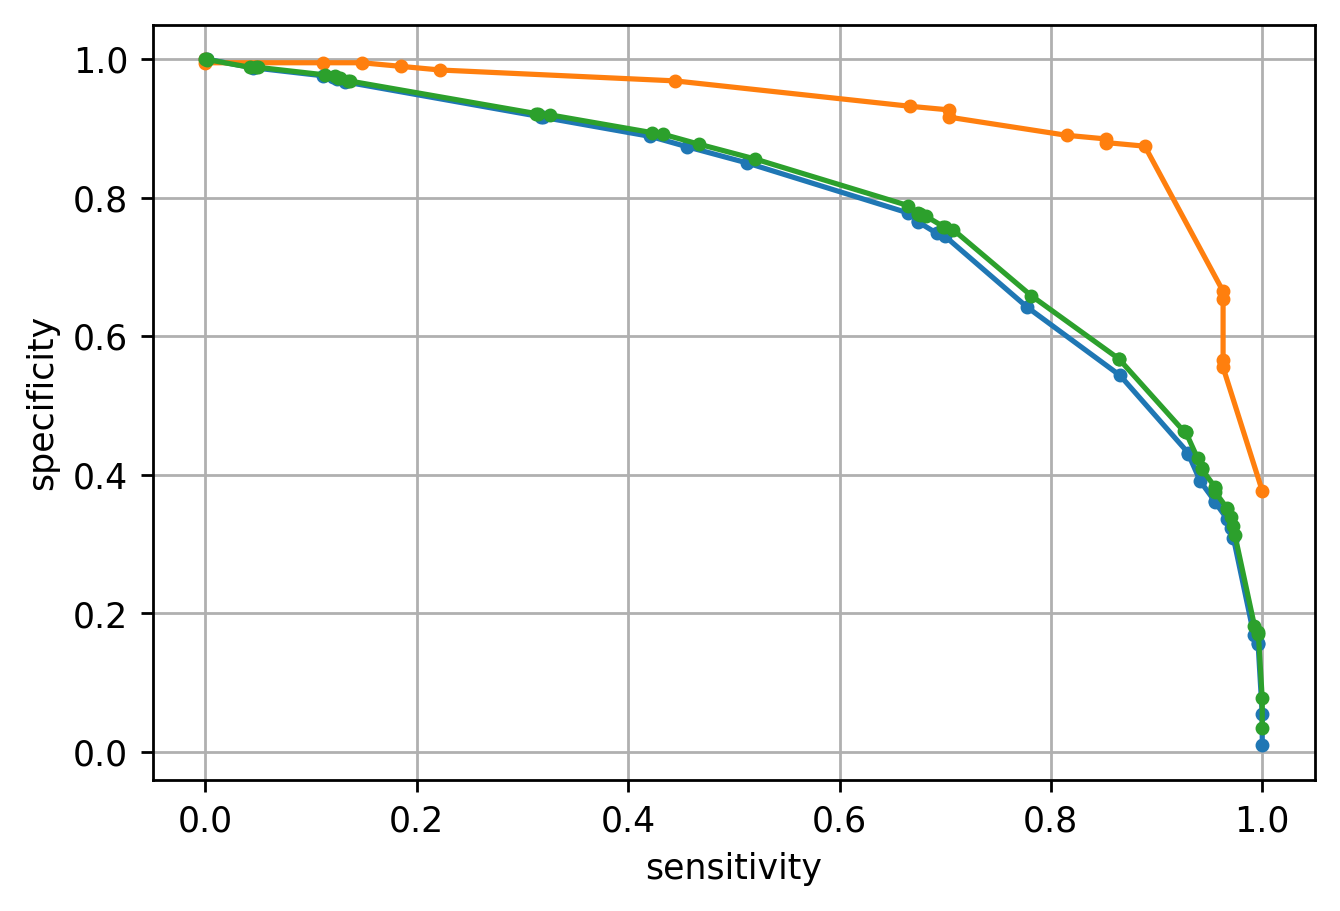

In [45]:
# predict_and_save(all_model_old, X_old, y_old, 'pfigs_old', '')
# predict_and_save(all_model_young, X_young, y_young, 'pfigs_young', '')
# predict_and_save(all_model_all, X_df_clean, y, 'pfigs_all', '')

In [47]:
# pkl.dump(all_model_old, open(oj(RESULT_PATH, 'all_model_old.pkl'), 'wb'))
# pkl.dump(all_model_young, open(oj(RESULT_PATH, 'all_model_young.pkl'), 'wb'))





# old vs new data

In [ ]:
X_not_old, y_not_old, feature_names_not_old = data_util.get_clean_dataset(
    f'{DATASET}_pecarn_pred.csv', data_source='imodels')
X_df_not_old = pd.DataFrame(X_not_old, columns=feature_names_not_old)

data/imodels_data/csi_pecarn_pred.csv


In [ ]:
X_df.columns

Index(['SITE', 'LOC', 'ambulatory', 'Predisposed', 'HighriskDiving',
       'HighriskFall', 'HighriskHanging', 'HighriskHitByCar', 'HighriskMVC',
       'HighriskOtherMV', 'AxialLoadAnyDoc', 'axialloadtop', 'Clotheslining',
       'AlteredMentalStatus2', 'FocalNeuroFindings2', 'PainNeck2',
       'PosMidNeckTenderness2', 'TenderNeck2', 'Torticollis2', 'subinj_Head2',
       'subinj_Face2', 'subinj_Ext2', 'subinj_TorsoTrunk2', 'is_ems',
       'Position_IDEMS', 'Position_L', 'Position_ND', 'Position_PA',
       'Position_S', 'Position_W', 'PtCompPainHead2', 'PtCompPainFace2',
       'PtCompPainExt2', 'PtCompPainTorsoTrunk2', 'PtTenderHead2',
       'PtTenderFace2', 'PtTenderExt2', 'PtTenderTorsoTrunk2', 'AgeInYears',
       'gender_F'],
      dtype='object')

In [ ]:
X_df_no_ND = X_df.drop(columns='Position_ND')

In [ ]:
X_df_no_ND.columns

Index(['SITE', 'LOC', 'ambulatory', 'Predisposed', 'HighriskDiving',
       'HighriskFall', 'HighriskHanging', 'HighriskHitByCar', 'HighriskMVC',
       'HighriskOtherMV', 'AxialLoadAnyDoc', 'axialloadtop', 'Clotheslining',
       'AlteredMentalStatus2', 'FocalNeuroFindings2', 'PainNeck2',
       'PosMidNeckTenderness2', 'TenderNeck2', 'Torticollis2', 'subinj_Head2',
       'subinj_Face2', 'subinj_Ext2', 'subinj_TorsoTrunk2', 'is_ems',
       'Position_IDEMS', 'Position_L', 'Position_PA', 'Position_S',
       'Position_W', 'PtCompPainHead2', 'PtCompPainFace2', 'PtCompPainExt2',
       'PtCompPainTorsoTrunk2', 'PtTenderHead2', 'PtTenderFace2',
       'PtTenderExt2', 'PtTenderTorsoTrunk2', 'AgeInYears', 'gender_F'],
      dtype='object')

In [ ]:
X_df_not_old.columns

Index(['SITE', 'LOC', 'ambulatory', 'Predisposed', 'HighriskDiving',
       'HighriskFall', 'HighriskHanging', 'HighriskHitByCar', 'HighriskMVC',
       'HighriskOtherMV', 'AxialLoadAnyDoc', 'axialloadtop', 'Clotheslining',
       'AlteredMentalStatus2', 'FocalNeuroFindings2', 'PainNeck2',
       'PosMidNeckTenderness2', 'TenderNeck2', 'Torticollis2', 'SubInjHead2',
       'SubInjFace2', 'SubInjExt2', 'SubInjTorsoTrunk2', 'IsEms',
       'Position_IDEMS', 'Position_L', 'Position_PA', 'Position_S',
       'Position_W', 'PtCompPainHead2', 'PtCompPainFace2', 'PtCompPainExt2',
       'PtCompPainTorsoTrunk2', 'PtTenderHead2', 'PtTenderFace2',
       'PtTenderExt2', 'PtTenderTorsoTrunk2', 'AgeInYears', 'gender_F'],
      dtype='object')

In [ ]:
X_df_no_ND.iloc[11]

SITE                     13.00
LOC                       1.00
ambulatory                0.00
Predisposed               0.00
HighriskDiving            0.00
HighriskFall              0.00
HighriskHanging           0.00
HighriskHitByCar          0.00
HighriskMVC               0.00
HighriskOtherMV           0.00
AxialLoadAnyDoc           0.00
axialloadtop              0.00
Clotheslining             0.00
AlteredMentalStatus2      1.00
FocalNeuroFindings2       0.00
PainNeck2                 0.00
PosMidNeckTenderness2     0.00
TenderNeck2               0.00
Torticollis2              0.00
subinj_Head2              1.00
subinj_Face2              0.00
subinj_Ext2               1.00
subinj_TorsoTrunk2        1.00
is_ems                    1.00
Position_IDEMS            0.00
Position_L                0.00
Position_PA               0.00
Position_S                1.00
Position_W                0.00
PtCompPainHead2           1.00
PtCompPainFace2           0.00
PtCompPainExt2            1.00
PtCompPa

In [ ]:
X_df_not_old.iloc[11]

SITE                     13.00
LOC                       1.00
ambulatory                0.00
Predisposed               0.00
HighriskDiving            0.00
HighriskFall              0.00
HighriskHanging           0.00
HighriskHitByCar          0.00
HighriskMVC               0.00
HighriskOtherMV           0.00
AxialLoadAnyDoc           0.00
axialloadtop              0.00
Clotheslining             0.00
AlteredMentalStatus2      1.00
FocalNeuroFindings2       0.00
PainNeck2                 0.00
PosMidNeckTenderness2     0.00
TenderNeck2               0.00
Torticollis2              0.00
SubInjHead2               1.00
SubInjFace2               0.00
SubInjExt2                1.00
SubInjTorsoTrunk2         1.00
IsEms                     1.00
Position_IDEMS            0.00
Position_L                0.00
Position_PA               0.00
Position_S                1.00
Position_W                0.00
PtCompPainHead2           1.00
PtCompPainFace2           0.00
PtCompPainExt2            1.00
PtCompPa

In [ ]:
np.where(np.all((X_df_not_old.values == X_df_no_ND.values), axis=1) == False)
# (X_df_not_old.columns == X_df.columns).all()

(array([  11,   56,   98,  135,  209,  217,  258,  277,  279,  282,  316,
         326,  397,  420,  486,  524,  560,  642,  681,  752,  784,  787,
         820,  824,  949,  972,  981,  989,  990,  995, 1001, 1054, 1076,
        1096, 1125, 1135, 1166, 1173, 1234, 1283, 1301, 1319, 1333, 1427,
        1450, 1464, 1512, 1514, 1519, 1529, 1534, 1613, 1616, 1621, 1659,
        1685, 1747, 1827, 1931, 1934, 1965, 2024, 2111, 2143, 2153, 2163,
        2170, 2304, 2333, 2399, 2402, 2427, 2431, 2468, 2471, 2475, 2496,
        2554, 2731, 2827, 2860, 2869, 2896, 2970, 3009, 3068, 3073, 3081,
        3082, 3087, 3109, 3135, 3147, 3173, 3179, 3210, 3287, 3292]),)

## incremental evaluation for CSI

In [47]:
young_trees = copy(all_model_young.trees_)
old_trees = copy(all_model_old.trees_)

In [48]:
all_model_young.trees_ = young_trees[:1]
all_model_old.trees_ = old_trees[:1]
all_model_all = TransferTree(all_model_young, all_model_old, is_group_1)

100%|██████████| 6/6 [00:00<00:00, 97.42it/s]


notebooks/transfertree/results/csi


100%|██████████| 5/5 [00:00<00:00, 565.15it/s]


notebooks/transfertree/results/csi


100%|██████████| 11/11 [00:00<00:00, 87.19it/s]


notebooks/transfertree/results/csi


({'sens': [0.9944444444444445,
   0.9907407407407407,
   0.9407407407407408,
   0.912962962962963,
   0.7481481481481481,
   0.4111111111111111,
   0.4074074074074074,
   0.40555555555555556,
   0.39444444444444443,
   0.012962962962962963,
   0.0],
  'spec': [0.07645149657410746,
   0.12225027046520015,
   0.41038586368553914,
   0.430219978362784,
   0.5953840605842048,
   0.8950595023440318,
   0.8957807428777498,
   0.8968626036783267,
   0.9015506671474937,
   0.9985575189325641,
   1.0],
  'ppv': [0.17333763718528084,
   0.18019535197036038,
   0.23705086327578162,
   0.23781958514230583,
   0.26474442988204455,
   0.4327485380116959,
   0.43222003929273084,
   0.43366336633663366,
   0.4382716049382716,
   0.6363636363636364,
   nan],
  'npv': [0.986046511627907,
   0.9854651162790697,
   0.9726495726495726,
   0.9620967741935483,
   0.9238947957470621,
   0.8864285714285715,
   0.8858773181169758,
   0.8856837606837606,
   0.8843296781039972,
   0.8385826771653543,
   0.8370057

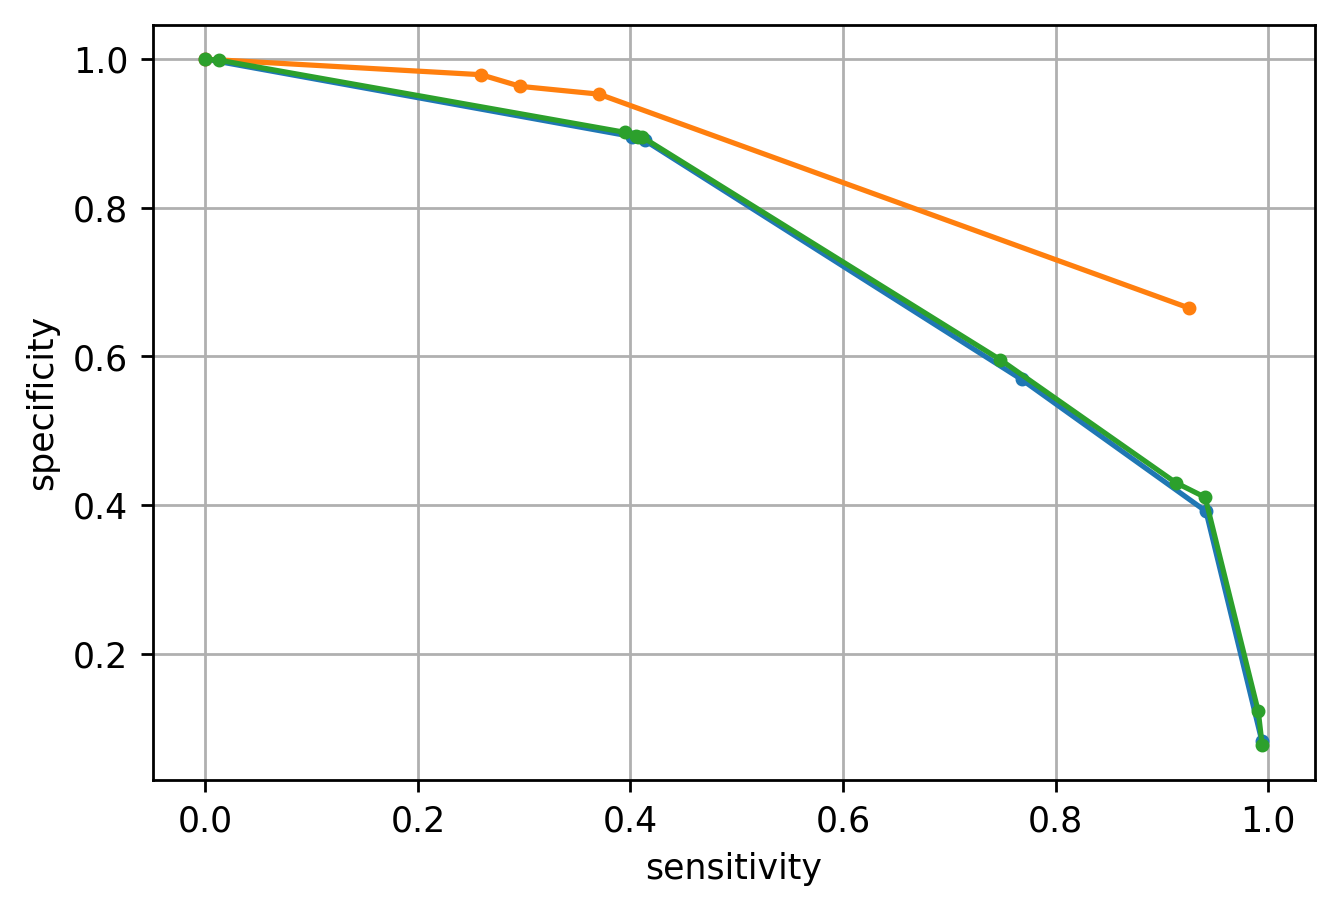

In [49]:
predict_and_save(all_model_old, X_old, y_old, 'pfigs_old_tree_1', '')
predict_and_save(all_model_young, X_young, y_young, 'pfigs_young_tree_1', '')
predict_and_save(all_model_all, X_df_clean, y, 'pfigs_all_tree_1', '')

In [50]:
all_model_young.trees_ = young_trees[:2]
all_model_old.trees_ = old_trees[:2]
all_model_all = TransferTree(all_model_young, all_model_old, is_group_1)

100%|██████████| 18/18 [00:00<00:00, 69.50it/s]


notebooks/transfertree/results/csi


100%|██████████| 13/13 [00:00<00:00, 622.34it/s]


notebooks/transfertree/results/csi


100%|██████████| 30/30 [00:00<00:00, 92.33it/s]


notebooks/transfertree/results/csi


({'sens': [1.0,
   0.9981481481481481,
   0.9907407407407407,
   0.987037037037037,
   0.9555555555555556,
   0.9518518518518518,
   0.9518518518518518,
   0.9407407407407408,
   0.9407407407407408,
   0.9351851851851852,
   0.9166666666666666,
   0.8388888888888889,
   0.7018518518518518,
   0.5944444444444444,
   0.5925925925925926,
   0.587037037037037,
   0.587037037037037,
   0.587037037037037,
   0.5777777777777777,
   0.42592592592592593,
   0.40925925925925927,
   0.30925925925925923,
   0.29814814814814816,
   0.2962962962962963,
   0.07962962962962963,
   0.07777777777777778,
   0.07592592592592592,
   0.06666666666666667,
   0.001851851851851852,
   0.0],
  'spec': [0.03714388748647674,
   0.09267940858276236,
   0.19870176703930761,
   0.20915975477821855,
   0.3671114316624594,
   0.37973314100252437,
   0.3862243058059863,
   0.41038586368553914,
   0.4111071042192571,
   0.42589253516047604,
   0.4673638658492607,
   0.5863685539127299,
   0.6996033177064551,
   0.809231

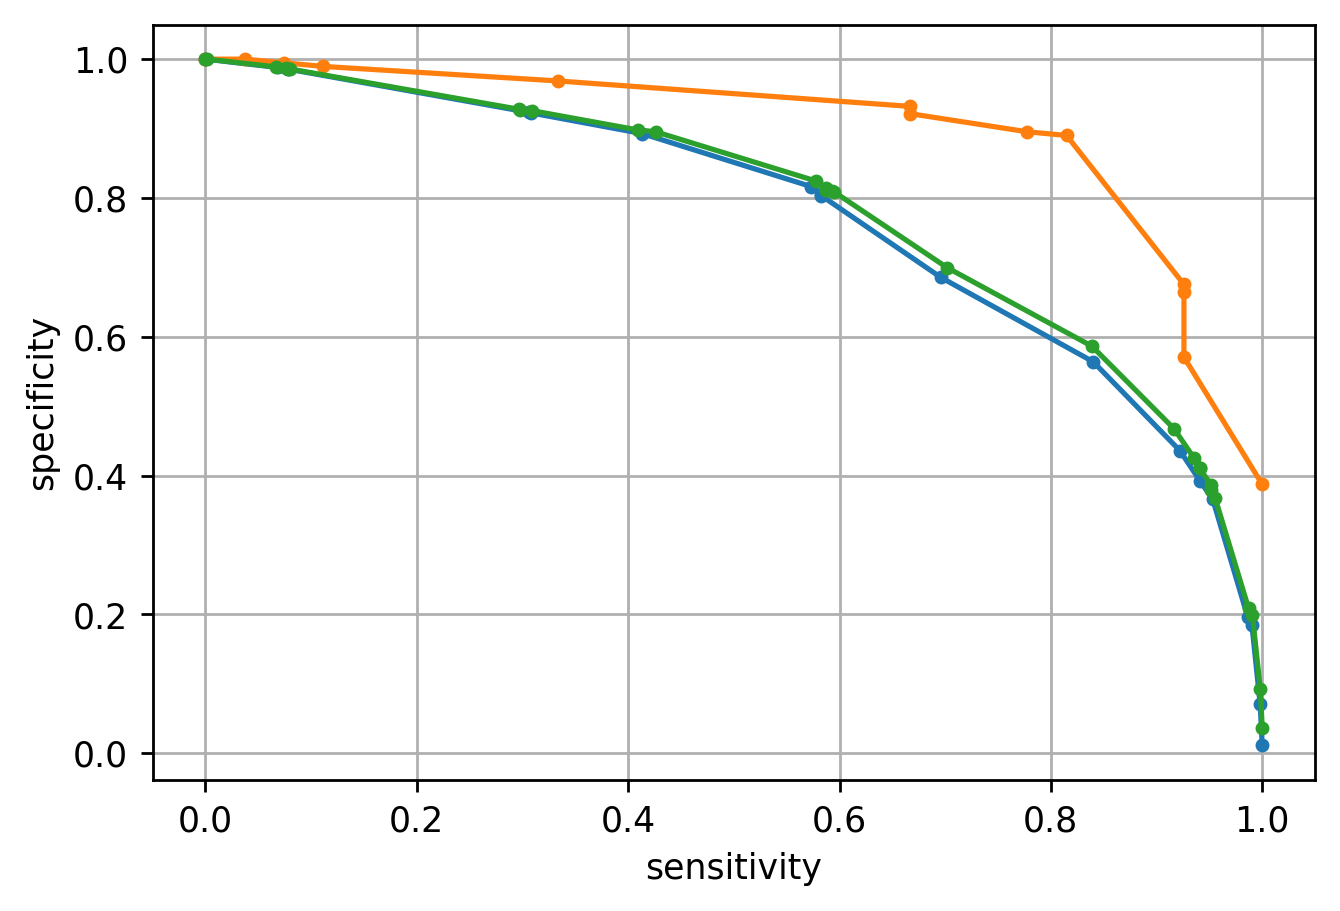

In [51]:
predict_and_save(all_model_old, X_old, y_old, 'pfigs_old_tree_2', '')
predict_and_save(all_model_young, X_young, y_young, 'pfigs_young_tree_2', '')
predict_and_save(all_model_all, X_df_clean, y, 'pfigs_all_tree_2', '')